In [334]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [335]:
import networkx as nx
import numpy as np
import torch

In [336]:
import wntr
import pandas as pd
import numpy as np

n_samples = 10

inp_file = 'network_file.inp'

# Fixed discharge coefficient for turbulent leaks
Cd = 0.75  

A_max = 0.5
# Leak areas from no leak to large leak
leak_ratio = np.linspace(0, A_max, n_samples)
leak_areas = 3.14159*(leak_ratio/2)**2

# This should match your reservoir pipe ID
reservoir_pipe_id = 'RESERVOIR'  # <-- change to your actual reservoir pipe name

results_list = []
flow_list = []

flow_values = []
pressure_values = []

for area in leak_areas:
    emitter_coeff = Cd * np.sqrt(area)
    
    wn = wntr.network.WaterNetworkModel(inp_file)
    junction = wn.get_node('JUNCTION-0')
    junction.add_leak(wn, area=area, discharge_coeff=0.75, start_time=0)
    

    sim = wntr.sim.WNTRSimulator(wn)
    results = sim.run_sim()

    pressure = results.node['pressure'].iloc[0]
    flow = results.link['flowrate'].iloc[0]
    
    flow_values.append(flow.values.item())
    pressure_values.append(pressure['JUNCTION-0'])
        
    
    #print(f"Leak Area: {area:.5f} m² --> Pressure: {pressure['JUNCTION-0']:.2f} m")

    # Store only the pressure at JUNCTION-0
    pressure_df = pd.DataFrame({
        'Leak Area (m²)': [area],
        'Pressure at JUNCTION-0 (m)': [pressure['JUNCTION-0']]
    })
    results_list.append(pressure_df)
    # Store only the flow through the reservoir pipe
    flow_df = pd.DataFrame({
        'Leak Area (m²)': [area],
        'Flowrate at Reservoir (m³/s)': flow.values
    })
    flow_list.append(flow_df)

# Combine results
pressures = pd.concat(results_list, ignore_index=True)
flows = pd.concat(flow_list, ignore_index=True)

display(pressures)
display(flows)


,Leak Area (m²),Pressure at JUNCTION-0 (m)
0,0.000000,49.990143
1,0.002424,49.959723
2,0.009696,49.764830
3,0.021817,49.140827
4,0.038785,47.742170
5,0.060602,45.253975
6,0.087266,41.541822
7,0.118779,36.769736
8,0.155140,31.384919
9,0.196349,25.951508


,Leak Area (m²),Flowrate at Reservoir (m³/s)
0,0.000000,0.050000
1,0.002424,0.106920
2,0.009696,0.277236
3,0.021817,0.558065
4,0.038785,0.940279
5,0.060602,1.404327
6,0.087266,1.918532
7,0.118779,2.442746
8,0.155140,2.937326
9,0.196349,3.372933


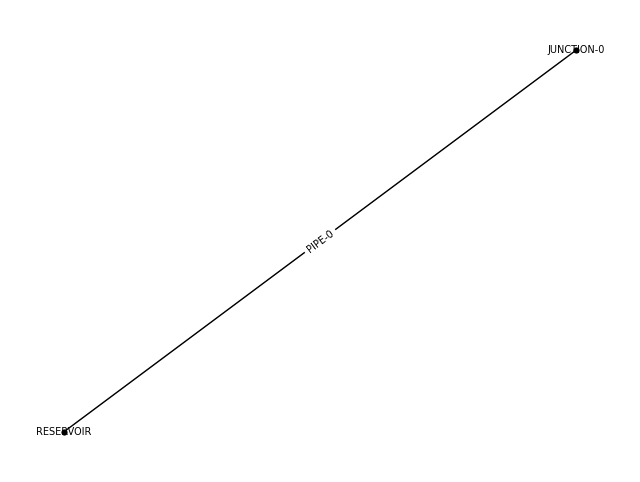

In [337]:
from wntr.graphics import plot_network
import matplotlib.pyplot as plt

# Plot just the structure of the network
fig, ax = plt.subplots(figsize=(8, 6))
plot_network(wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [338]:
G = wn.to_graph()
A = nx.incidence_matrix(G)
reservoirs = list(wn.reservoir_name_list)
# Get all node names (junctions, tanks, reservoirs)
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = [n for n in all_nodes if n not in reservoirs]

idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]

# Get adjacency matrix using filtered nodelist
A  = nx.incidence_matrix(G)
A0 = torch.tensor(A[idx,:].toarray(), dtype=torch.float32)



In [339]:
from scipy.sparse import dok_matrix

edgelist = list(G.edges())
supply_nodes = wn.reservoir_name_list  # or include tanks if needed
supply_nodes = list(supply_nodes)  # Ensure it's ordered

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [340]:
junctions = wn.junction_name_list  # Only junctions have demand

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand  # in m³/s
    D_values.append(demand)

# D is a NumPy array aligned with junction_name_list
D = torch.tensor(D_values, dtype=torch.float32)
print(D)

tensor([0.0500])


In [341]:
# Get supply node names
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)
print(S)


tensor([50.])


In [342]:
pipe_names = wn.pipe_name_list  # List of all pipe IDs

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

print(C)

tensor([100.])


In [343]:
model_params = {
    'A0': A0,
    'B' : B,
    'A_max' : leak_areas.max(),
    'S' : S,
    'D' : D,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
    'n_samples' : 1
}

net_params = {
        'layer_sizes' : [96,96,96,A0.shape[1]], 
        'activation' : 'sigmoid',
}


In [344]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=1000)

step       loss       e1          e2
1000       4.12e-05   New Best!
2000       2.05e-11   New Best!
3000       2.79e-12   New Best!
4000       5.68e-14   New Best!
5000       5.68e-14   
6000       5.68e-14   
7000       5.68e-14   
8000       5.68e-14   
9000       5.68e-14   
10000      5.68e-14   
11000      5.68e-14   
12000      5.68e-14   
13000      5.68e-14   
14000      5.68e-14   
15000      5.68e-14   
16000      5.68e-14   
17000      5.68e-14   
18000      5.68e-14   
19000      5.68e-14   
20000      5.68e-14   
21000      5.68e-14   
22000      5.68e-14   
23000      5.68e-14   
24000      5.68e-14   
25000      5.68e-14   
26000      5.68e-14   
27000      5.68e-14   
28000      5.68e-14   
29000      5.68e-14   
30000      5.68e-14   
31000      5.68e-14   


KeyboardInterrupt: 

In [345]:
import torch

# Step 1: Prepare input tensor from leak areas
A = torch.tensor(leak_areas, dtype=torch.float32).reshape(-1, 1)

#A = torch.linspace(leak_areas.max(), leak_areas.max(), 1).reshape(-1, 1)


# Step 2: Predict pressure and flow using the trained model
H = model.net(A)  # Predicted pressure at JUNCTION-0
H = H.detach().flatten()
#q = q.detach().flatten()

# Step 3: Append predicted values to the dataframes

# Append to `final_results` (pressure data)
pressures['Predicted Pressure at JUNCTION-0 (m)'] = H
pressures['Pressure Error (m)'] = pressures['Predicted Pressure at JUNCTION-0 (m)'] - pressures['Pressure at JUNCTION-0 (m)']

# Append to `pipe_flows` (flowrate data)
# flows['Predicted Flowrate at Reservoir (m³/s)'] = q
# flows['Flowrate Error (m³/s)'] = flows['Predicted Flowrate at Reservoir (m³/s)'] - flows['Flowrate at Reservoir (m³/s)']

# Display updated tables
print("\n=== Final Results (Pressures) with Predictions ===")
display(pressures)

# print("\n=== Pipe Flows (Reservoir) with Predictions ===")
# display(flows)



=== Final Results (Pressures) with Predictions ===


,Leak Area (m²),Pressure at JUNCTION-0 (m),Predicted Pressure at JUNCTION-0 (m),Pressure Error (m)
0,0.000000,49.990143,25.955324,-24.034819
1,0.002424,49.959723,25.955324,-24.004399
2,0.009696,49.764830,25.955328,-23.809502
3,0.021817,49.140827,25.955334,-23.185493
4,0.038785,47.742170,25.955345,-21.786825
5,0.060602,45.253975,25.955355,-19.298620
6,0.087266,41.541822,25.955368,-15.586454
7,0.118779,36.769736,25.955383,-10.814353
8,0.155140,31.384919,25.955400,-5.429518
9,0.196349,25.951508,25.955420,0.003912


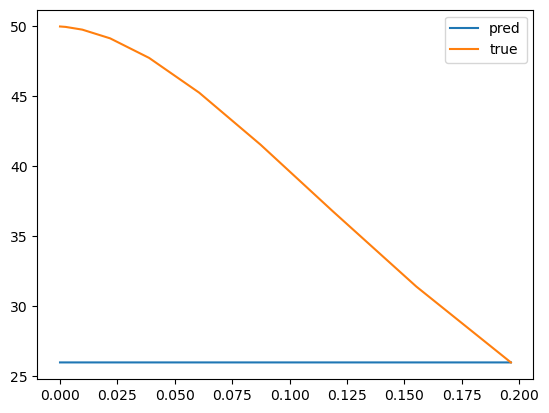

In [346]:
A = torch.linspace(0, leak_areas.max(), 10).reshape(-1, 1)
H = model.net(A)  # Predicted pressure at JUNCTION-0

A = A.detach()

plt.plot(leak_areas, H.detach().flatten(), label='pred')
plt.plot(leak_areas, pressure_values, label='true')
plt.legend()
plt.show()

torch.Size([10, 1])


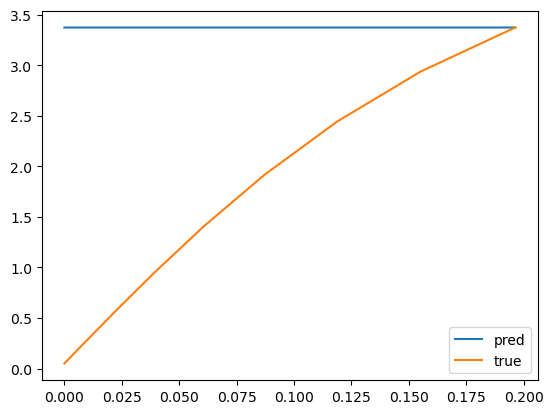

In [347]:
hL = B @ S - model.mv(A0.T, H)
print(H.shape)


q = torch.sign(hL) * (torch.abs(hL) * C**(1.852) * d**(4.871) / 10.667 / L)**(1 / 1.852)

plt.plot(leak_areas, q.detach().flatten(), label='pred')
plt.plot(leak_areas, flow_values, label='true')
plt.legend()
plt.show()